In [1]:
#__Import libraries and script needed__
# Standard libraries
import numpy as np
import matplotlib.pyplot as plt

# System and Path Libraries for Module Import
import os
import sys

# Set up the Project Path
# Add this line to your ~/.bashrc or ~/.zshrc: export REALTIMEID_PATH='/absolute/path/to/project'
project_path = os.environ.get('REALTIMEID_PATH')
if project_path and project_path not in sys.path:
    sys.path.append(project_path)
    print("Project path successfully added.")
else:
    print("Warning: 'REALTIMEID_PATH' environment variable is not set.")

# Import Custom Modules for Green's Function Kernel Analysis
from src.discr_error.discr_error import DiscrError  # Class for discretization error analysis and related functions
from src.dlr_kernel.dlr_kernel import DlrKernel  # Interpolative decomposition and utilities (e.g., effective coupling computation)
from src.utils import common_funcs as cf  # Utilities for grid generation, spectral density computations, etc.

Project path successfully added.


In [2]:
#_____Set Parameters______

DEFAULT_PHI = np.pi / 4
params = {
    "m": None,  # to be updated for each computation
    "n": None,  # to be updated for each computation
    "N_max": None,  # not specified as we will directly pass the time grids "times"
    "delta_t": 0.1,  #this step that we will use below to set the time grids
    "beta": 20.0,  # inverse temperature
    "upper_cutoff": 600.,  # frequency cutoff for continous integrations
    "h": None,  # to be updated for each computation
    "phi": DEFAULT_PHI,
}  # either "N_max" and "delta_t" OR "times" needs to be specified to define the time grid. If all is specified, the argument "times" is used as time grid


h_vals = np.log(
    np.arange(2, 1.0, -0.01)
)  # array with values of h which should be explored.
nbr_iterations = len(h_vals)

In [3]:
#_______Evaluate the error between the dicrete-frequency approximation and the continous-frequency integral_____
N_maxs = np.arange(50,200,20)
delta_t = 0.1

# create empty array in which to store DiscrError objects
discr_errors = np.empty(shape=(len(N_maxs),nbr_iterations), dtype=object)


for tau, N_max in enumerate(N_maxs):
    
    cf.update_parameters(params, {"N_max": N_max})
    times = cf.set_time_grid(N_max=params["N_max"], delta_t= params["delta_t"])
    
    #_______Compute continuous integral results________
    cont_integral = np.array(
        [
            cf.cont_integral(t, params["beta"], params["upper_cutoff"])
            for t in times
        ]
    )  # array containing all values for the continuous integration result

    for i, h in enumerate(h_vals):
        cf.update_parameters(params, {"h": h})

        discr_error = DiscrError(
            **params, cont_integral_init=cont_integral
        )  # DiscrError object which holds the error w.r.t. to the continous results, and all associated parameters.

        discr_error.optimize()  # optimize values for m and n

        #Exit the loop it error is below machine precision of if it does not keep shrinking with smaller h. Otherwise, append to array
      
        if cf.check_error_condition(
            eps_current=discr_error.eps,
            eps_previous=discr_errors[tau,i-1].eps if i > 1 else np.infty,
        ):
            break
        else:
            discr_errors[tau, i] = discr_error


Either the error does not shrink with decreasing h or the machine precision error was reached. Error = 0.0050617933631762575. Stopping the iteration.
Either the error does not shrink with decreasing h or the machine precision error was reached. Error = 2.359213459716045e-16. Stopping the iteration.
Either the error does not shrink with decreasing h or the machine precision error was reached. Error = 0.0011559471071089836. Stopping the iteration.
Either the error does not shrink with decreasing h or the machine precision error was reached. Error = 2.628488934202769e-16. Stopping the iteration.
Either the error does not shrink with decreasing h or the machine precision error was reached. Error = 1.4004685708296759e-15. Stopping the iteration.
Either the error does not shrink with decreasing h or the machine precision error was reached. Error = 2.3367259011691557e-15. Stopping the iteration.
Either the error does not shrink with decreasing h or the machine precision error was reached. Err

In [4]:
#_____Evaluate the Real-time Kernel and its interpolative decomposition (ID)___
D = np.array([[DlrKernel(discr_errors[tau,i]) for i in range (nbr_iterations)] for tau in range (len(N_maxs))]) # Use DiscrError object to initialize the kernel. This ensures that consistency of all parameters.

In [5]:
#_______Extract the data that we want to visualize below________
errors, m_vals, n_vals, h_vals, ID_ranks = cf.create_numpy_arrays(D)
nbr_modes_total = m_vals + n_vals

In [6]:
#_______Set global plot parameters____________
plt.rcParams.update({"text.usetex": True, "font.family": "Helvetica", "font.size": 8})
cmaps = [plt.get_cmap("Blues"), plt.get_cmap("Reds")]
colors_blue = cmaps[0](np.linspace(0.35, 0.9, len(N_maxs)))
colors_orange = cmaps[1](np.linspace(0.35, 0.9, len(N_maxs)))

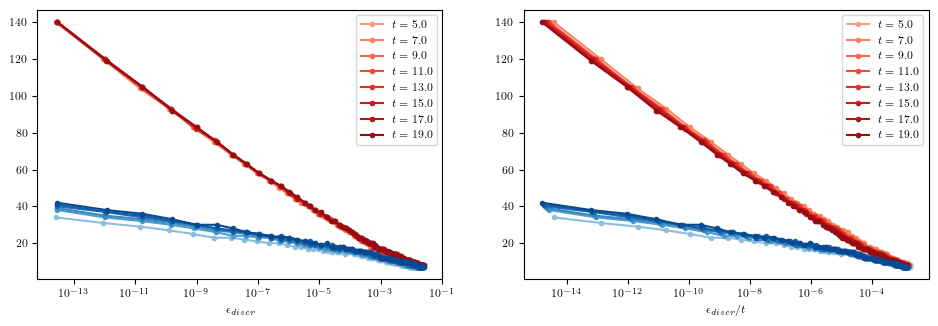

In [7]:
#_____Plot the number of modes versus the error and the discretization parameter h____
fig, axs = plt.subplots(1, 2, figsize=(11.5, 3.5))
for tau in range (len(N_maxs)):
    mask = errors[tau] != 0.0#mask to filter values that are zero (i.e. no value avaliable)
    axs[0].plot(errors[tau,mask],nbr_modes_total[tau,mask],color=colors_orange[tau],marker="o",linestyle="-",markersize=3, label = r'$t={}$'.format(N_maxs[tau] * delta_t))
    axs[0].plot(errors[tau,mask], ID_ranks[tau,mask], color=colors_blue[tau], marker="o", linestyle="-", markersize=3)
    
axs[0].set_xlabel(r"$\epsilon_{discr}$")
#axs[0].text(1.e-8, 30, "Red: m+n,\n Blue: ID-rank")
axs[0].legend()
axs[0].set_xscale("log")

for tau in range (len(N_maxs)):
    mask = errors[tau] != 0.0#mask to filter values that are zero (i.e. no value avaliable)
    axs[1].plot(errors[tau,mask]/(N_maxs[tau] * delta_t),nbr_modes_total[tau,mask],color=colors_orange[tau],marker="o",linestyle="-",markersize=3, label = r'$t={}$'.format(N_maxs[tau]* delta_t))
    axs[1].plot(errors[tau,mask]/(N_maxs[tau] * delta_t), ID_ranks[tau,mask], color=colors_blue[tau], marker="o", linestyle="-", markersize=3)
    
axs[1].set_xlabel(r"$\epsilon_{discr} / t$")
#axs[1].text(1.e-8, 30, "Red: m+n,\n Blue: ID-rank")
axs[1].legend()
axs[1].set_xscale("log")

#plt.savefig("./plots/collapse.pdf", bbox_inches='tight')
